In [427]:
import os
import sys
import torch

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from src import BASE_DIR

from src.models.dcgan_lsun import *
import numpy as np
from matplotlib import pyplot as plt
from src.utils.visualization import create_grid_image

# Investigating and visualizing the internals of the networks

## 1. Walking in latent space

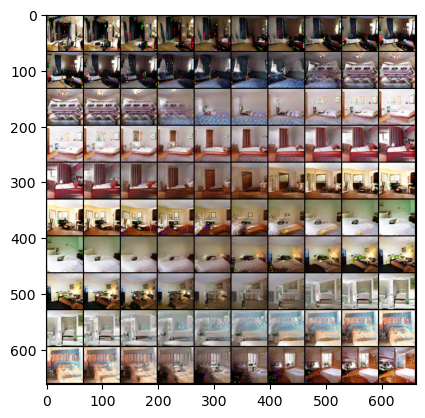

In [428]:
torch.manual_seed(2405)
# noise
num_noise = 11
noises = torch.randn(num_noise, 100)
G = Generator(ngf=128)
try:
    G.load_state_dict(torch.load(os.path.join(BASE_DIR,'models/LSUN/gen_params_10.pth')))
except FileNotFoundError:
    print("Not exist model params. You can train model with LSUN dataset or get pretrained param from this link: https://drive.google.com/file/d/16hnQmRKY4x3gPFI2lxydqAtakmnfVISm/view?usp=sharing")


interpolated_list = []
# interpolation between 2 noise point
with torch.no_grad():
    for i in range(num_noise - 1):
        z1, z2 = noises[i], noises[i+1]
        for coef in np.linspace(0,1,10):
            interpolated = (1 - coef) * z1 + coef * z2
            interpolated_list.append(interpolated)

images = G(torch.stack(interpolated_list))
grid_image = create_grid_image(images=images, num_row=10, save=True, path_to_save=os.path.join(BASE_DIR,'reports/LSUN/interpolated.png'))
plt.imshow(grid_image)


## 2. Visualizing discriminator features

In [214]:
class SumNet(nn.Module):
    def __init__(self) -> None:
        super(SumNet,self).__init__()
        self.c1 = nn.Conv2d(2,4,1,1)
        self.relu1 = nn.ReLU()
        self.c2 = nn.Conv2d(4,8,1,1)
        self.relu2 = nn.ReLU()
        self.c3 = nn.Conv2d(8,16,1,1)
    
    def forward(self, a):
        c = self.relu1(self.c1(a)) 
        print('shape', c.shape)
        c = self.relu2(self.c2(c))
        print('shape', c.shape)
        c = self.c3(c)
        print('shape', c.shape)
        return c
    
class GBP(nn.Module):
    """An easy implementation of GBP, using a resnet bone.
    """
    def __init__(self, model):
        super(GBP, self).__init__()
        self.bone = model
        self.bone.eval()
        self.activation_maps = []
        self.set_backprop()

    def set_backprop(self):
        """Setting up backpropagation of Guided Backpropagation
        """
        def forward_hook_fn(module, input, output):
            print('--------------------------')
            print('module:', str(module), '\nshape:', output[0].shape)
            self.activation_maps.append(output)
        # Hook function. Filter out all the negative gradients and pass through.
        def relu_backward_hook(module, grad_out, grad_in):
            modified_grad_out = nn.functional.relu(grad_out[0])
            return (modified_grad_out, )

        # Register the backward hook function for all ReLU layers.
        for idx, item in enumerate(self.bone.modules()):
            item.register_backward_hook(forward_hook_fn)
            if isinstance(item, nn.ReLU):
                item.register_backward_hook(relu_backward_hook)


    def generate_gradient(self, input, target):
        # Forward through network
        input.requires_grad = True
        model_output = self.bone(input)
        print('output shape', model_output.shape)
        self.bone.zero_grad()

        # Build initial gradient
        init_grad = torch.zeros_like(model_output).float()
        init_grad[0][target] = 1.

        # Backward through network
        model_output.backward(gradient=init_grad)

        # Return the gradient
        return input.grad

    def forward(self, input, target):
        return self.generate_gradient(input, target)


sum_net = SumNet()
model = GBP(sum_net)
img_tensor = torch.ones(2,4,4)
grad = model(img_tensor, 0)

shape torch.Size([4, 4, 4])
shape torch.Size([8, 4, 4])
shape torch.Size([16, 4, 4])
output shape torch.Size([16, 4, 4])
--------------------------
module: Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1)) 
shape: torch.Size([16, 4, 4])
--------------------------
module: SumNet(
  (c1): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
  (relu1): ReLU()
  (c2): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
  (relu2): ReLU()
  (c3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
) 
shape: torch.Size([16, 4, 4])
--------------------------
module: ReLU() 
shape: torch.Size([8, 4, 4])
--------------------------
module: Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1)) 
shape: torch.Size([8, 4, 4])
--------------------------
module: ReLU() 
shape: torch.Size([4, 4, 4])
--------------------------
module: Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1)) 
shape: torch.Size([4, 4, 4])


/home/daoduyhung/anaconda3/envs/cs231n_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [185]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

class SumNet(nn.Module):
    def __init__(self) -> None:
        super(SumNet,self).__init__()
        self.c1 = nn.Conv2d(2,2,1,1)
        self.relu1 = nn.ReLU()
        self.c2 = nn.Conv2d(2,2,1,1)
        self.relu2 = nn.ReLU()
        self.c3 = nn.Conv2d(2,2,1,1)
    
    def forward(self, a):
        c = self.relu1(self.c1(a))
        c = self.relu2(self.c2(c))
        c = self.c3(c)
        return c

class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None # store R0
        self.activation_maps = []  # store f1, f2, ... 
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def first_layer_hook_fn(module, grad_out, grad_in):
            self.image_reconstruction = grad_out[0]

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_out, grad_in):
            grad = self.activation_maps.pop() 
            # for the forward pass, after the ReLU operation, 
            # if the output value is positive, we set the value to 1,
            # and if the output value is negative, we set it to 0.
            grad[grad > 0] = 1 
            
            # grad_in[0] stores the gradients for each feature map,
            # and we only retain the positive gradients
            print(str(module), len(grad_in))
            positive_grad_in = torch.clamp(grad_in[0], min=0.0)
            new_grad_out = positive_grad_in * grad

            return (new_grad_out,)


        # AlexNet model 
        modules = list(self.model.named_children())

        # travese the modules，register forward hook & backward hook
        # for the ReLU
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        # register backward hook for the first conv layer
        first_layer = modules[0][1]
        first_layer.register_backward_hook(first_layer_hook_fn)

    def visualize(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()
        
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1
        
        model_output.backward(grad_target_map)
        
        result = self.image_reconstruction.data[0].permute(1,2,0)
        return result.numpy()

def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm


# image = Image.open('./dog.jpg').convert('RGB') 

# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])


# tensor = transform(image).unsqueeze(0).requires_grad_()
tensor = torch.ones(2,2,2)    
model = SumNet()
print('AlexNet Architecture:\n', '-'*60, '\n', model, '\n', '-'*60)

guided_bp = Guided_backprop(model)
result = guided_bp.visualize(tensor, None)

# result = normalize(result)
# plt.imshow(result)
# plt.show()

AlexNet Architecture:
 ------------------------------------------------------------ 
 SumNet(
  (c1): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
  (relu1): ReLU()
  (c2): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
  (relu2): ReLU()
  (c3): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))
) 
 ------------------------------------------------------------
ReLU() 1
ReLU() 1


/home/daoduyhung/anaconda3/envs/cs231n_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [163]:
class SumNet(nn.Module):
    def __init__(self) -> None:
        super(SumNet,self).__init__()
        self.c1 = nn.Conv2d(2,2,1,1)
        self.relu1 = nn.ReLU()
        self.c2 = nn.Conv2d(2,2,1,1)
        self.relu2 = nn.ReLU()
        self.c3 = nn.Conv2d(2,2,1,1)
    
    def forward(self, a):
        c = self.relu1(self.c1(a))
        c = self.relu2(self.c2(c))
        c = self.c3(c)
        return c
    
sum_net = SumNet()
modules = list(sum_net.named_children())
modules[0][1]

Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1))

In [219]:
import torch
import matplotlib.pyplot as plt
from  torchvision.models import resnet18
# Define the input x and the model
x = torch.randn(1, 3, 224, 224, requires_grad=True)
model = resnet18()

# Forward pass to get the output
output = model(x)

# Backward pass to calculate the gradients
grads = torch.autograd.grad(outputs=output, inputs=x, grad_outputs=torch.ones_like(output))[0]
print(grads.shape)
# Get the gradient of the output with respect to the neuron of interest
neuron_grad = grads[0, 10] # Gradient of the first input in the batch with respect to neuron 10

# Normalize the gradient
norm = torch.norm(neuron_grad)
if norm != 0:
    neuron_grad = neuron_grad / norm

# Multiply the normalized gradient with the input
guided_backprop = x * neuron_grad.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

# Visualize the resulting image
plt.imshow(torch.transpose(guided_backprop.squeeze(), 0, 2).detach().numpy())
plt.show()

torch.Size([1, 3, 224, 224])


IndexError: index 10 is out of bounds for dimension 1 with size 3

In [519]:
class GuidedBackprop():
    def __init__(self, model, candidate_layers) -> None:
        self.fmaps = {}
        self.grads = {}
        self.features = {}
        self.model = model
        self.image_reconstruction = None
        self.candidate_layers = candidate_layers
        self.modules = list(model.named_modules())

        def first_layer_hook_fn(module, grad_out, grad_in):
            print('first', module)
            self.image_reconstruction = grad_out[0]

        def save_fmaps(key):
                def forward_hook(module, input, output):
                    print('forward_input', input[0].shape)
                    print('forward_output', output[0].shape)
                    self.fmaps[key] = output

                return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_out, grad_in):
                print('backward_input', grad_in[0].shape)
                print('backward_output', grad_out[0].shape)
                self.grads[key] = grad_out[0]
                self.features[key] = grad_in[0]
                if isinstance(module, nn.ReLU):
                     return (F.relu(grad_in[0]),)

            return backward_hook

        for name, module in self.modules:
            # name follows module name in code
            if self.candidate_layers is None or name in self.candidate_layers:
                module.register_forward_hook(save_fmaps(name))
                module.register_backward_hook(save_grads(name))
        
        self.modules[1][1].register_backward_hook(first_layer_hook_fn)
    
    def generate_grad(self, input):
        input.requires_grad = True
        output = self.model(input)
        print(output)
        self.model.zero_grad()
        init_grad = torch.tensor(1).float()
        # output.backward(init_grad)
        # print('reconstructed_image shape', self.image_reconstruction.shape)

        conv4_fmaps = self.fmaps['conv4']
        init_conv4_grad = torch.zeros_like(conv4_fmaps).float()
        init_conv4_grad[0] = conv4_fmaps[0][0]
        conv4_fmaps.backward(init_conv4_grad)
        print('reconstructed_image shape', self.image_reconstruction.shape)

torch.Size([1, 3, 64, 64])


tensor(0.9986, grad_fn=<SqueezeBackward0>)

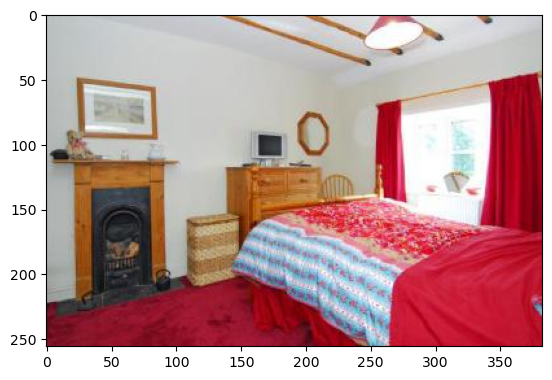

In [517]:
from torchvision import transforms

from src.data.LSUN.transforms import *

listdir = os.listdir('../../DCGAN/data/LSUN/bedroom_train_data/')
path = listdir[0]
image = Image.open(os.path.join(BASE_DIR,'data/LSUN/bedroom_train_data/',path))
plt.figure()
plt.imshow(image)
# G = Generator()
# G.load_state_dict(torch.load(os.path.join(BASE_DIR, 'models/LSUN/gen_params_10.pth')))
# noise = torch.randn((1,100))
# fake_image = G(noise)
# topil = transforms.ToPILImage()
# plt.imshow(topil(fake_image.squeeze()))

composed = transforms.Compose([
    ReScale(64),
    CenterCrop(),
    transforms.ToTensor()
])


image = composed(image).unsqueeze(0)
print(image.shape)
D = Discriminator()
D.load_state_dict(torch.load(os.path.join(BASE_DIR, 'models/LSUN/dis_params_10.pth')))

D(image)

forward_input torch.Size([1, 512, 8, 8])
forward_output torch.Size([1024, 4, 4])
tensor(0.9983, grad_fn=<SqueezeBackward0>)
backward_input torch.Size([1, 1024, 4, 4])
backward_output torch.Size([1, 512, 8, 8])
first Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
reconstructed_image shape torch.Size([1, 3, 64, 64])


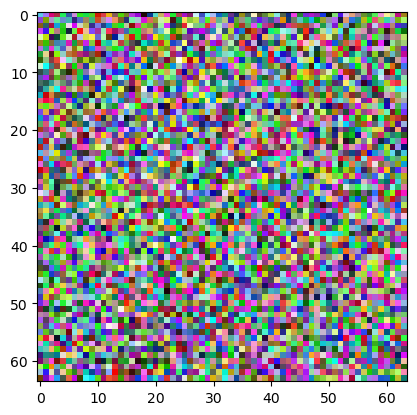

In [520]:
D = Discriminator()
D.load_state_dict(torch.load(os.path.join(BASE_DIR, 'models/LSUN/dis_params_1.pth')))
gbp = GuidedBackprop(D, ['conv4'])

# image = torch.zeros((1,3,64,64))
fmap_number = 0
gbp.generate_grad(image)
for key, value in gbp.fmaps.items():
    # print(key, value.shape)
    reconstructed_fmap = torch.zeros_like(value)
    reconstructed_fmap[0][fmap_number] = value[0][fmap_number]

trans = transforms.ToPILImage()
plt.imshow(trans(gbp.image_reconstruction.squeeze()))